### Poisson

In [95]:
import numpy as np
import pandas as pd
import arviz as az
import pymc as pm
import matplotlib.pyplot as plt
import xarray as xr
az.style.use("arviz-whitegrid")
RANDOM_SEED = 8927
RNG = np.random.default_rng(RANDOM_SEED)

In [186]:
df = pd.read_csv('dataset.csv')
# Map languages to integers and hold mapping for later;
df["language"], languages = pd.factorize(df["language"])
df["project_type"], project_types = pd.factorize(df["project_type"])

df.head()   

,project,language,commits,insertions,age,bugs,project_type,devs
0,4clojure,0,629,9180,774,128,0,21
1,4clojure,1,75,39240,509,29,0,10
2,AFIncrementalStore,2,196,5624,362,74,1,24
3,AFNetworking,2,952,50099,962,403,2,128
4,ActionBar-PullToRefresh,3,213,14657,192,68,1,5


# Prior Predictive Checks and Modelling

Model number of bugs with a poisson regression, to get the expected count of bugs for some language. To model the average number of bugs without any effect of language, the poisson regression can be defined as ;
Poisson Regression : $$ B_i \sim Poisson(\lambda_i) \\
log(\lambda_i) = \alpha \\
\alpha \sim ??$$

Now what is a good choice of priors for alpha?

* One thing we can we say for sure is that number of counts cannot be negative but the question is how many bugs an average project might have? First of all, there need to be some software pushed to the project, which is denoted by the number of commits **C**. As soon as a project has one commit, there must also be some probability that there is some bug in that pushed code. Based on own work experience, the number commits depending on what type of project, can range from a few commits to a 100. Some projects we believe are much bigger meaning they have much more commits. A naive livable space for the expected number of bugs would be in the interval $\lambda_i \in [0, \infty)$. Based on our own experience, say that our project has a 100 commits and we are terrible programmers with some systematic interchange of letters, this project would have a 100 bugs, so this is still a very large upper bound for the number of bugs. A more reasonable upper bound could maybe be $1000$. 

* This interval $\lambda_i \in [0, 1000)$ is aimed to be reflected in the choice of prior for $\alpha$ that is the average number of bugs for a project.
* Since the expected value $\lambda$ is has an logarithmic relationship  to $\alpha$, the choice of priors can lead to either exploding number of bugs with a prior with high variance, or a common choice the unit $N(0,1)$ could lead to negative samples, that are mapped to almost expected values of bugs around 0. This might also seem to good to be true.

* Three candidate prior distributions for alpha:
    * $\alpha \sim Exp(1)$
    * $\alpha \sim N(0,1)$
    * $\alpha \sim log \ N(0,1)$


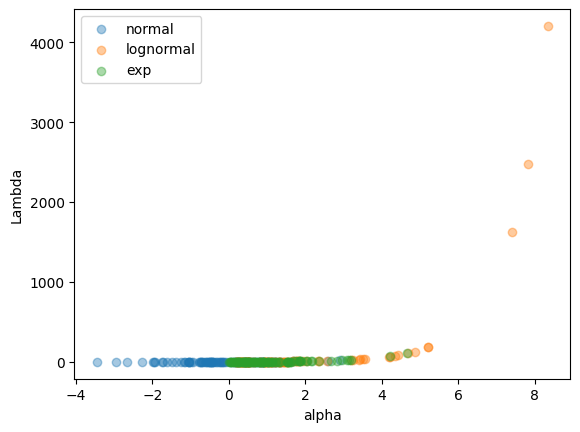

In [41]:
# First Initial Check
n_draws = np.random.normal(0, 1, 100)
ln_draws = np.random.lognormal(0,1,100)
exp_draws = np.random.exponential(1, 100)

plt.scatter(n_draws,np.exp(n_draws),label="normal", alpha=0.4)
plt.scatter(ln_draws,np.exp(ln_draws),label="lognormal", alpha=0.4)
plt.scatter(exp_draws,np.exp(exp_draws), label="exp",alpha=0.4)
plt.xlabel("alpha")
plt.ylabel("Lambda")
plt.legend()
plt.show()

From the plot above, it is already clear that the lognormal distribution yields exploding values for the number of bugs on average, from the x-axis showing the alpha values.

We can also see, that the normal distribution yields (as expected) a bunch of negative samples, that results in the average number of bugs to be very close to $0$. The exponential distributions heavy tailed characteristic shows from this initialisation a greater tendency than the $N (0,1)$ to yield exploding values. 

Next we run the prior predictive checks comparing the normal and exponential distribution, to find a good informative prior.


In [82]:
def prior_predictive_check_alpha_normal(alpha_mu_prior, alpha_sigma_prior):
    with pm.Model() as model:
        alpha = pm.Normal("alpha", mu=alpha_mu_prior, sigma=alpha_sigma_prior)
        lam = pm.Deterministic('lambda', pm.math.exp(alpha))
        # B = pm.Poisson('B', mu=lam, observed=df.bugs)
        
        trace = pm.sample_prior_predictive(samples=100)
        
    return trace, model

def prior_predictive_check_alpha_exp(alpha_lambda_prior):
    with pm.Model() as model:
        alpha = pm.Exponential("alpha", alpha_lambda_prior)
        lam = pm.Deterministic('lambda', pm.math.exp(alpha))
        # B = pm.Poisson('B', mu=lam, observed=df.bugs)
        trace = pm.sample_prior_predictive(samples=100)
        
    return trace, model

Sampling: [alpha]
Sampling: [alpha]
Sampling: [alpha]
Sampling: [alpha]
Sampling: [alpha]
Sampling: [alpha]
Sampling: [alpha]


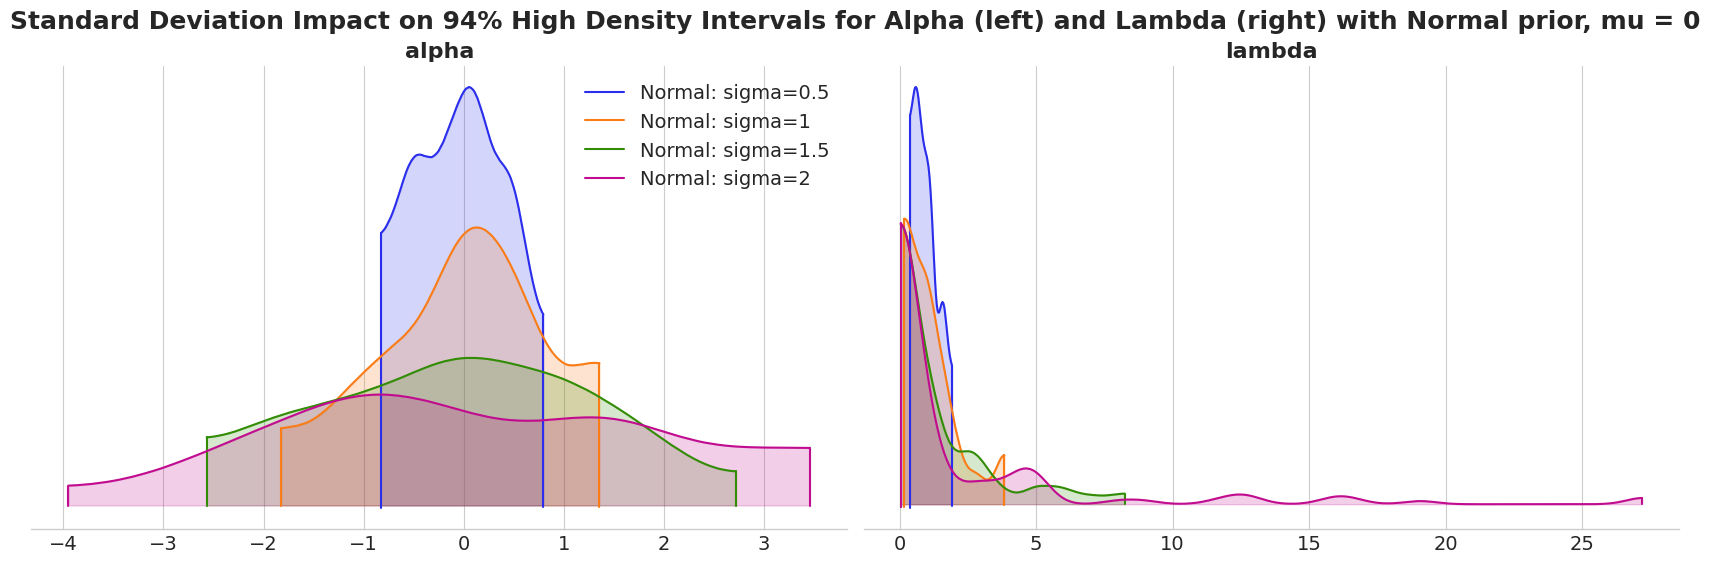

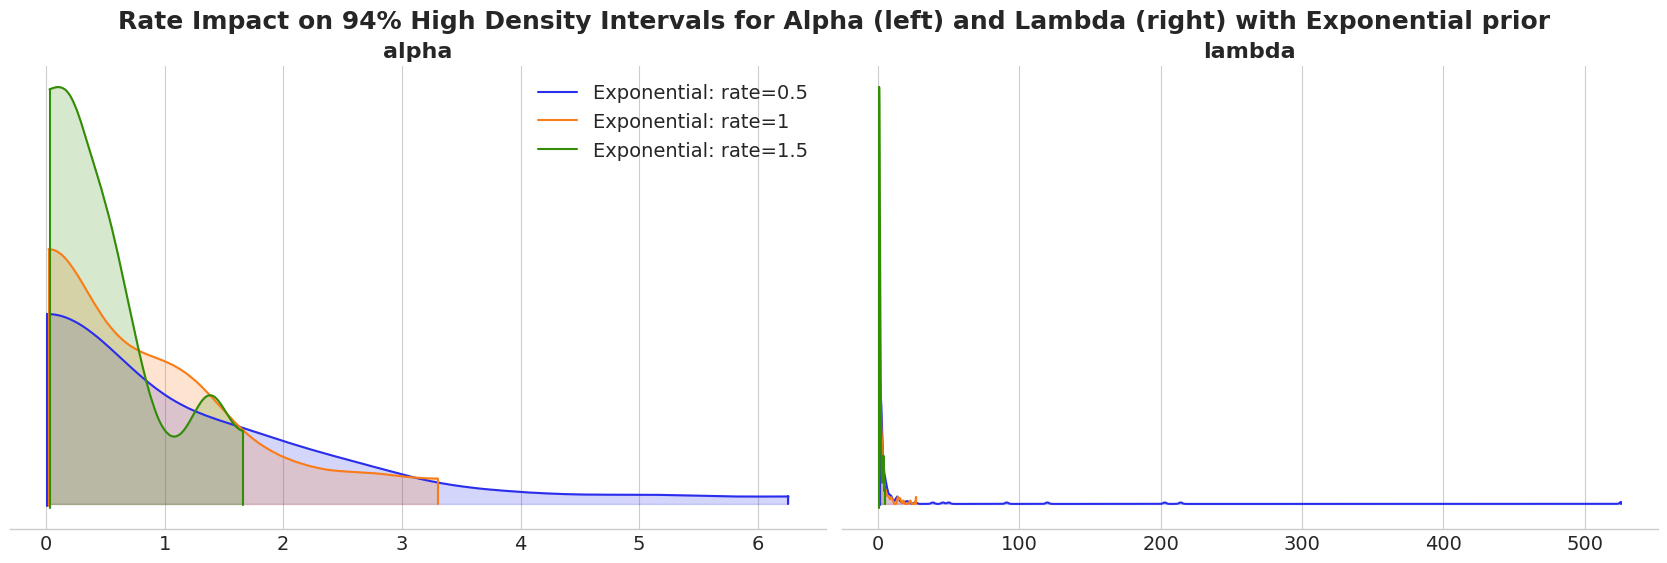

In [96]:
# Fixed Mu, varying sigmas
# Varying rate/lambda parameters
mu = 0
n_sigmas = [0.5, 1, 1.5, 2]
exp_lambdas = [0.5, 1, 1.5]


normal_traces, exponential_traces = [], []
normal_labels, exponential_labels = [], []


for sigma in n_sigmas:
    trace, model = prior_predictive_check_alpha_normal(mu, sigma)
    normal_traces.append(trace.prior)
    normal_labels.append(f"Normal: sigma={sigma}")

for exp in exp_lambdas:
    trace, model = prior_predictive_check_alpha_exp(exp)
    exponential_traces.append(trace.prior)
    exponential_labels.append(f"Exponential: rate={exp}")

axes = az.plot_density(
    normal_traces,
    data_labels=normal_labels,
    var_names=["alpha", "lambda"],
    shade=0.2,
    point_estimate=None,
)

fig = axes.flatten()[0].get_figure()
fig.suptitle("Standard Deviation Impact on 94% High Density Intervals for Alpha (left) and Lambda (right) with Normal prior, mu = 0")

axes = az.plot_density(
    exponential_traces,
    data_labels=exponential_labels,
    var_names=["alpha", "lambda"],
    shade=0.2,
    point_estimate=None,
)

fig = axes.flatten()[0].get_figure()
fig.suptitle("Rate Impact on 94% High Density Intervals for Alpha (left) and Lambda (right) with Exponential prior")

plt.show()


* Based on the above KDE plots and prior predictive checks for Normal distribution with varying $\sigma$ and fixed $\mu=0$ and exponential distribution with varying rates, it is clear that small changes in the rate (lambda) parameter of an exponential distribution is over sensitive to changes in terms of pushing the average simulated number of bugs too close to $0$ or stretches it too far out, as it is seen with $\lambda = 0.5$. The normal distribution seem to be more a suitable choice of priors for the alpha values, although even with a $\sigma=2$ the simulated number of bugs gets a very heavy tail. Now to find the best prior, we fix the standard deviation of 1.5, and try to rid the models from most of the negative values by increasing the $\mu$ parameter.

Sampling: [alpha]
Sampling: [alpha]
Sampling: [alpha]


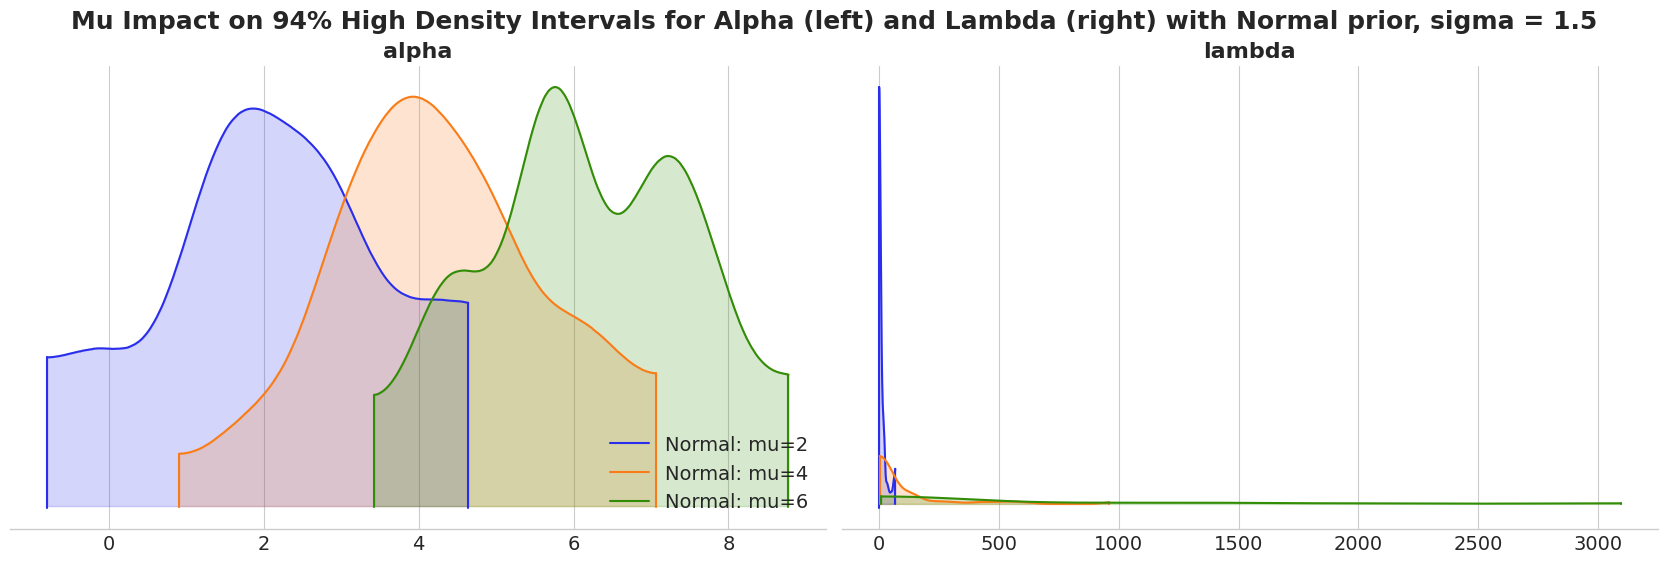

In [104]:
#Fixed Sigma, varying mu
sigma = 1.5
n_mus = [2, 4, 6]

traces, labels = [], []

for mu in n_mus:
    trace, model = prior_predictive_check_alpha_normal(mu, sigma)
    traces.append(trace.prior)
    labels.append(f"Normal: mu={mu}")

axes = az.plot_density(
    traces,
    data_labels=labels,
    var_names=["alpha", "lambda"],
    shade=0.2,
    point_estimate=None,
)

fig = axes.flatten()[0].get_figure()
fig.suptitle("Mu Impact on 94% High Density Intervals for Alpha (left) and Lambda (right) with Normal prior, sigma = 1.5")
plt.show()

Based on the varying means in the prior predictive sampling for parameters $\alpha$ & $\lambda$ for the poisson distribution, the choise of prior for modeling the average number bugs with $\alpha$ is $N(\mu=6, \sigma=1.5)$ since it shows from the plot above and highlighted below, that the probability mass lies within the range of $[0,\approx 5000)$, which indicates outlying projects of 5 order of magnitudes bigger that the average project of $1000$ bugs. This is 10 times more than our own personal projects have had of commits, but these have also been tiny projets, and therefore not representative of what we expect from commercial applications commits and bugs distributions.

$$\alpha \sim N(6,1.5)$$

Sampling: [alpha]


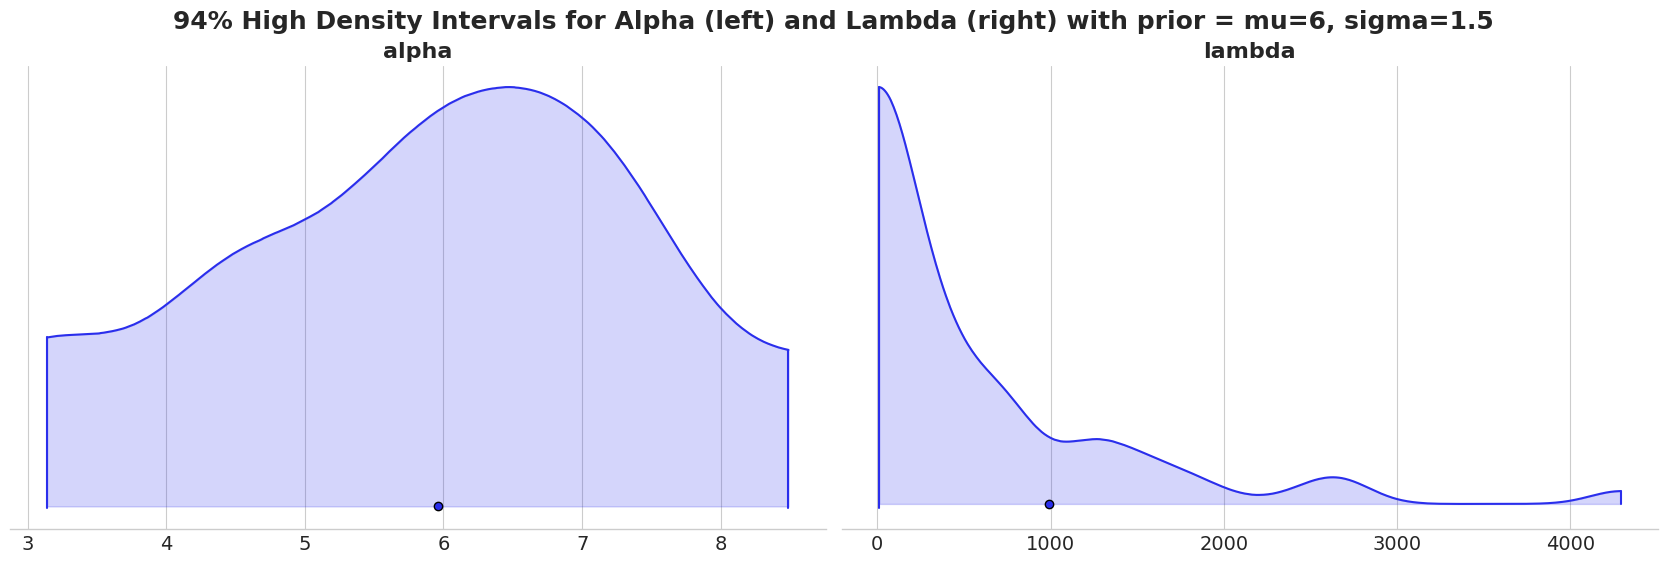

In [123]:
axes = az.plot_density(
    [prior_predictive_check_alpha_normal(6, 1.5)[0].prior],
    data_labels=["Prior Alpha selection = mu=4, sigma=1.5"],
    var_names=["alpha", "lambda"],
    shade=0.2,
    point_estimate="mean",
)

fig = axes.flatten()[0].get_figure()
fig.suptitle("94% High Density Intervals for Alpha (left) and Lambda (right) with prior = mu=6, sigma=1.5")
plt.show()

# Effects of Language

As **H1** is stated as follows, it is important to include the effects of language somehow into our poisson regression;

* **H1** - Haskell code is less prone to contain bugs (B). In other words, the distribution on the number of bugs (B) for Haskell gives high probability to the lowest number of bugs among all programming languages (L).

We include language as predictors for our poisson regression such that :


Poisson Regression : $$ B_i \sim Poisson(\lambda_i) \\
log(\lambda_i) = \alpha + \beta_l * langauge \\
\alpha \sim N(6,1.5) \\ 
\beta_l \sim ??$$

$$l \in L, where \ L = \{Python,Java..,C \} \\ |L|=17 $$


A prior predictive check is again important for having a reasonable estimate for the impact of language. The choice of prior should not explicitly state a positive nor negative relationship between expected number of bugs $\lambda$ and any language. Ideally, it is a flat prior that can pickup, the different effects from a specific language on the number of bugs, from the data. 

This is investigated in the code below. The starting point is an uninformative prior of a standard normal, as we would like coefficients centered around both $0$ with both negative and positive samples, to simulate, that some languages might have a positive or negative correlation with the number of bugs for a project. Similarly, the prior normal $\sigma$ values below are $\leq 1.5$, to constrain all the languages.


/var/folders/90/hzvrpycd5ds6jx99ygz9bbk00000gn/T/ipykernel_66392/219158400.py:31: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


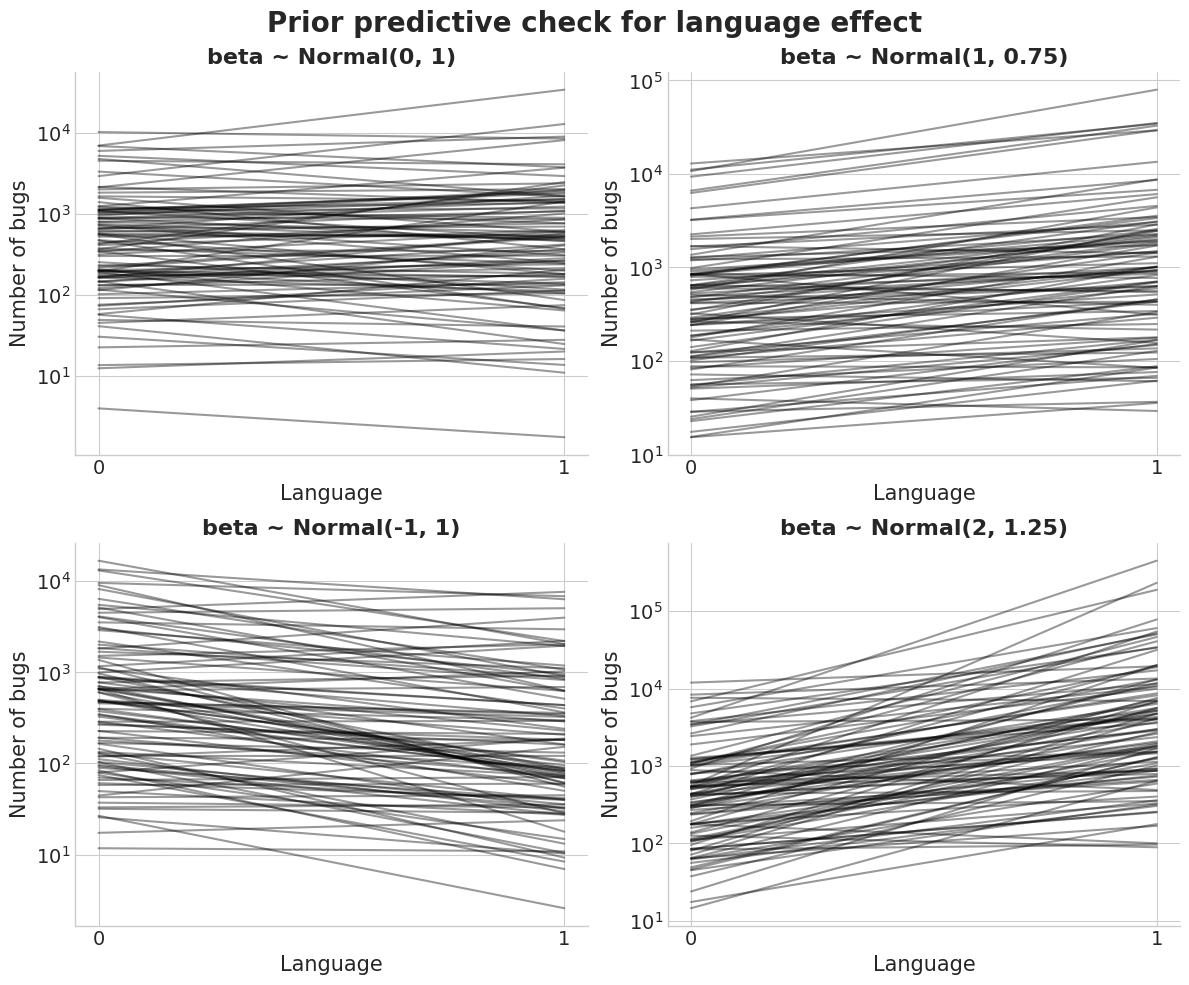

In [130]:
# Adding a language effect
def plot_prior_predictive_check(b_mean,b_std, N: int = 100):
    alphas = np.random.normal(6, 1.5, N)
    betas = np.random.normal(b_mean, b_std, N)
    prior_samples_language_effects = []
    x_axis_data = []
    for a, b in zip(alphas, betas):
        x_seq = np.array([0, 1]) # one hot encoding for language
        # plt.plot(x_seq, np.exp(a + b * x_seq), 'k', alpha=0.4)
        prior_samples_language_effects.append(np.exp(a + b * x_seq))
        x_axis_data.append(x_seq)
    
    return x_axis_data, prior_samples_language_effects

means = [0, 1, -1,2]
stds = [1, 0.75, 1, 1.25, 1.5]

fig, axis = plt.subplots(2,2, figsize=(12, 10))

for mu,std,ax in zip(means, stds, axis.reshape(-1)):
    x_axis_data, prior_samples_language_effects = plot_prior_predictive_check(mu, std)
    for x_seq, y_seq in zip(x_axis_data, prior_samples_language_effects):
        ax.plot(x_seq, y_seq, 'k', alpha=0.4)
    ax.set_title('beta ~ Normal({}, {})'.format(mu, std))
    ax.set_xticks([0, 1])
    ax.set_xlabel("Language")
    ax.set_yscale("log")
    ax.set_ylabel('Number of bugs')

fig.suptitle('Prior predictive check for language effect', fontsize=20)
plt.tight_layout()

The best choice of prior for the beta coefficients is an uninformed standard normal distribution $$\beta_l \sim N(0,1)$$ This choice does not include any positive or negative trends simply based on the project's programming language, and this is desirable for our poisson regression :
Poisson Regression : $$ B_i \sim Poisson(\lambda_i) \\
log(\lambda_i) = \alpha + \beta_l * langauge \\
\alpha \sim N(6,1.5) \\ 
\beta_l \sim N(0,1)$$

# Poisson Regression

The danger for a GLM poisson regression with this dataset is that if a certain language has on average project sizes that are on average multiple orders magnitude greater than other languages, the model might pick up on some false relationships between languages and the number of bugs, simply because the projects written in that language contain more bugs. ( lead to binomial)
* First try only model only with alphas for each language to see if there is an average effect on the number of bugs
* Check if there is any effect from one language over the other simply 

#### Model Fitting

$$ B_i \sim Poisson(\lambda_i) \\
log(\lambda_i) = \alpha + \beta_l * langauge \\
\alpha \sim N(6,1.5) \\ 
\beta_l \sim N(0,1)$$

In [169]:
## Poisson Modeling
with pm.Model() as poisson_normal:

      #Data
      language = pm.Data("language", df.language, mutable=True)
      # Priors
      alpha = pm.Normal("alpha", mu=0, sigma=10)
      beta_language = pm.Normal("beta_language", mu=0, sigma=1, shape = len(languages))

      #f(theta)
      lam= pm.Deterministic('lambda', pm.math.exp(alpha+beta_language[language]*language))

      #likelihood
      B = pm.Poisson('B', mu=lam, observed=df.bugs)

      trace = pm.sample(2000, tune=2000,idata_kwargs={'log_likelihood': True}, random_seed=RANDOM_SEED, chains=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta_language]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 9 seconds.


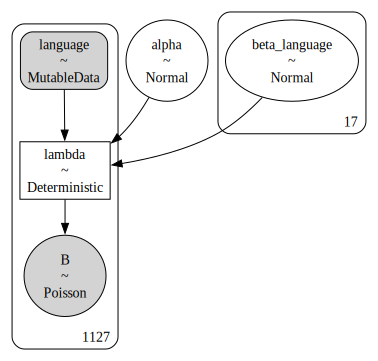

In [170]:
pm.model_to_graphviz(model=poisson_normal)

Below is the trace convergence for the parameters $\alpha$ and $\beta_l$.

The number of generated samples is 4 chains * 2000 samples = 8000 samples.

As seen in the table below, the Monte Carlo Standard Error MSCE, is $0$ for all parameters except for $beta_language[0]$ of $0.01$. These MSCE's indicate effective sampling of the mode of the distributions in all 4 chains, whilst the equivalent entries in mcse_sd show the chains could sample efficiently. This is also shown by the $>1000$ for the ess_bulk and ess_tails, that shows the numnber samples that added new information about the posterior distribution.

In addition, all the rhat values are $1.0$ which means the 4 chains converged. This is also reflected in the trace plot below, which shows good mixing of the chains.

In summary, the convergence of the trace for the poisson regression
 is good and shows no signs of inefficient of inaccuracte sampling. We can therefore use the posterior distributions with high confidence.

In [171]:
az.summary(trace, var_names=["alpha", "beta_language"], round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,4.79,0.01,4.77,4.81,0.00,0.00,1004.38,1472.93,1.0
beta_language[0],-0.01,1.00,-1.91,1.83,0.01,0.01,5331.40,4740.09,1.0
beta_language[1],0.47,0.01,0.44,0.49,0.00,0.00,1144.49,1812.87,1.0
beta_language[2],0.02,0.01,0.00,0.04,0.00,0.00,1796.58,3089.78,1.0
beta_language[3],0.46,0.00,0.45,0.47,0.00,0.00,1143.40,1858.96,1.0
beta_language[4],0.48,0.00,0.48,0.49,0.00,0.00,1116.14,1881.20,1.0
beta_language[5],0.42,0.00,0.42,0.43,0.00,0.00,1111.28,1689.07,1.0
beta_language[6],-0.09,0.00,-0.09,-0.08,0.00,0.00,3121.98,3960.32,1.0
beta_language[7],0.42,0.00,0.41,0.42,0.00,0.00,1030.69,1499.08,1.0
beta_language[8],0.25,0.00,0.25,0.26,0.00,0.00,1102.54,1606.74,1.0


# inspection of model

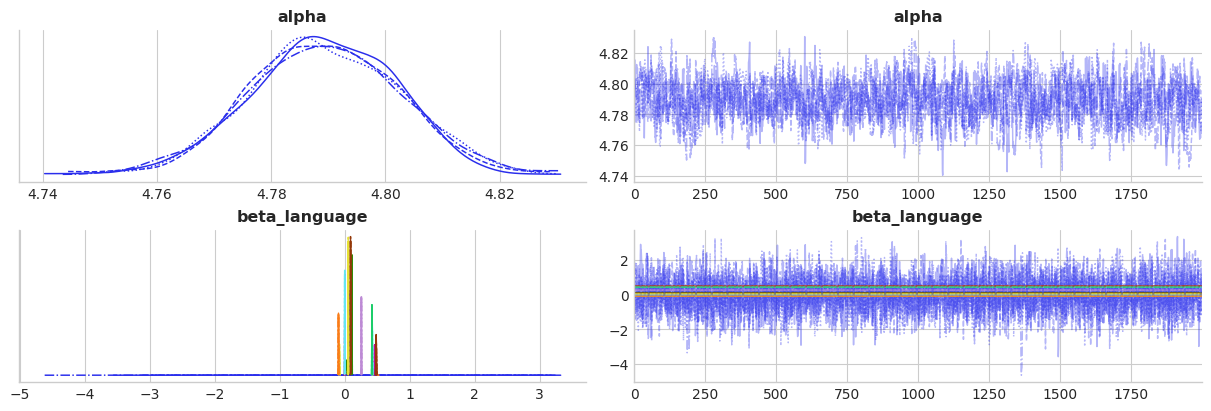

In [172]:
pm.plot_trace(trace, var_names=['alpha', "beta_language"]);

Below the $\mu$ and $\sigma$ inspected from the posterior distributions of the **$\beta$** and $\alpha$. The prior $\mu=6$ is now reduced to $\mu=4.97893$ with a high confidence shown by the $\sigma=0.0131$. This shows that the average number of bugs was overestimated by the prior, but also that the sampling was able to estimate it with high accuracy. Similarly, all the $\beta_l$ except for the $\beta_0$ has very small standard deviations. This also indicates the confidence of the estimated distributions. The $\mu$ of the $\beta$ distributions show different effects of some languages over the others, but all fall within the small range of $(-0.0981,0.4820)$. Especially the negative effects are notably very close to 0, whereas the largest value $\mu$ for $\beta_4=0.4820$, which indicates a positive correlation between this particular language and the number of bugs. These differences are also seen below in forest plot.

In [173]:
pm.summary(trace, var_names=['alpha', 'beta_language'],round_to=4)[['mean', 'sd']]

,mean,sd
alpha,4.7893,0.0131
beta_language[0],-0.0123,0.9955
beta_language[1],0.4685,0.0141
beta_language[2],0.0194,0.0090
beta_language[3],0.4569,0.0047
beta_language[4],0.4820,0.0035
beta_language[5],0.4223,0.0028
beta_language[6],-0.0853,0.0045
beta_language[7],0.4168,0.0019
beta_language[8],0.2545,0.0017


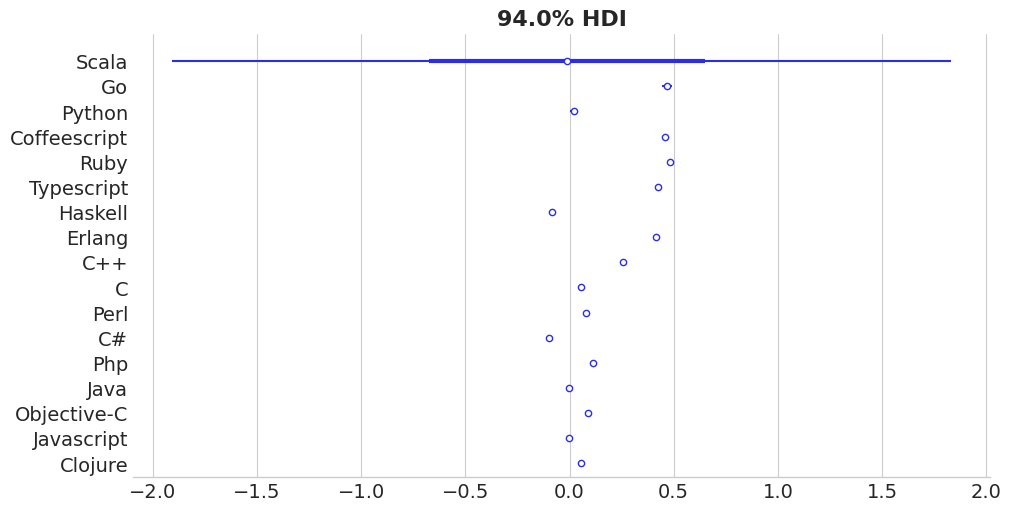

In [214]:
ax = az.plot_forest(trace, var_names=["beta_language"], combined=True, figsize=(10, 5))
ax[0].set_yticklabels(languages); 
# Languages yields same mapping as languages.take(trace.posterior.data_vars["beta_language"].indexes["beta_language_dim_0"])

## Posterior Predictive Check

In [175]:
pareto_k_h2 = az.loo(trace, pointwise=True).pareto_k.values

/Users/AFFO/.pyenv/versions/3.10.4/envs/prob_prog/lib/python3.10/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


In [177]:
n_points = len(df)
print(f'Number of points sampled: {n_points}')
x_seq = np.random.randint(0, 16,size=n_points)
print(x_seq)
with poisson_normal:
    pm.set_data({"language": x_seq})
    post_pred_h2 = pm.sample_posterior_predictive(trace, var_names=["B"])['posterior_predictive']['B']
    
post_pred_h2_mean = post_pred_h2.mean(["chain", "draw"])

Sampling: [B]


Number of points sampled: 1127
[10  1  1 ...  9 11  7]


/Users/AFFO/.pyenv/versions/3.10.4/envs/prob_prog/lib/python3.10/site-packages/matplotlib/collections.py:996: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


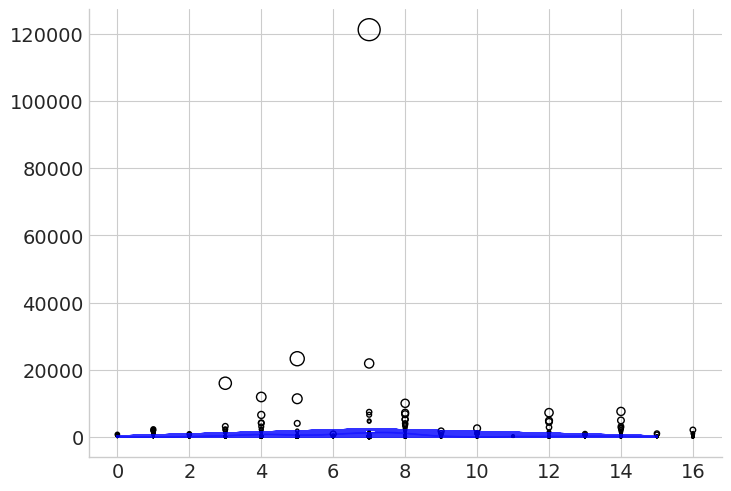

In [213]:
#scale pareto-k values by their max and changing make them nice to plot
pareto_k_h2 /= pareto_k_h2.max()
pareto_k_h2_size = 250 * pareto_k_h2

#Get the 10 data points with the largest pareto_k_values
top_indices = np.argsort(pareto_k_h2)[-10:][::-1]
top_data_points = df.iloc[top_indices]

az.plot_hdi(x_seq, post_pred_h2, color = 'b', fill_kwargs={'alpha': 0.4}, ax=plt)
plt.plot(x_seq, post_pred_h2_mean, color = 'b', alpha=0.8, label='Mean')
plt.scatter(df.language, df.bugs, s = pareto_k_h2_size, facecolors='none', edgecolors='k', lw=1)

In [180]:
top_data_points 

,project,language,commits,insertions,age,bugs,project_type,devs
636,linux,7,305361,27056685,3199,121302,6,437
683,mono,5,61113,9087186,4606,23260,1,439
827,platform_frameworks_base,3,25254,4284943,1913,15957,2,637
689,monodevelop,5,22456,5829989,3040,11333,2,141
199,WordPress,4,21712,726818,3945,11861,4,49
810,php-src,7,41154,4922903,5401,21848,5,299
877,rails,12,28240,1181687,3344,7187,1,1382
709,mythtv,8,21442,1839994,4296,9973,4,68
379,django,14,10545,674402,3113,7558,2,160
289,cakephp,4,13753,1645998,3171,6506,1,220
